# Fine-movement characterization

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from datetime import datetime
from scipy.interpolate import interp1d

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import umap

from one.api import ONE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
# from plotting_functions import bins_per_trial_phase, broader_label
from data_processing import process_quiescence, interpolate
from wheel_functions import wheel_trial_epoch
one = ONE(base_url='https://alyx.internationalbrainlab.org')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/api.py:1465: UserWarning: Newer cache tables require ONE version 2.7 or greater
  warnings.warn(f'Newer cache tables require ONE version {min_version} or greater')


## Load data

In [ ]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Wheel/processed/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/processed/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/'
os.chdir(data_path)
data_files = os.listdir(data_path)

### Color code by trial epoch

In [246]:
wheel_data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/'
wheel_data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Wheel/'
os.chdir(wheel_data_path)
df = pickle.load(open('wheel_movements_1_604e1da8-1e3d-41c4-a29e-21d573a0b84c', "rb"))
df = pickle.load(open('wheel_movements_last_7330f879-8dfc-4344-af84-cd422199bddc', "rb"))
df = pickle.load(open('wheel_movements_last_f857c0ca-863f-40e0-85f9-53104e55be44', "rb"))

processed_data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/processed/'
processed_data_path = '/home/ines/repositories/representation_learning_variability/DATA/Wheel/processed/'
os.chdir(processed_data_path)
processed_quiescence = pickle.load(open('processed_quiescence_1_604e1da8-1e3d-41c4-a29e-21d573a0b84c', "rb"))
processed_quiescence = pickle.load(open('processed_quiescence_last_7330f879-8dfc-4344-af84-cd422199bddc', "rb"))
processed_quiescence = pickle.load(open('processed_quiescence_last_f857c0ca-863f-40e0-85f9-53104e55be44', "rb"))

# Naive: 604e1da8-1e3d-41c4-a29e-21d573a0b84c
# Expert: 7330f879-8dfc-4344-af84-cd422199bddc

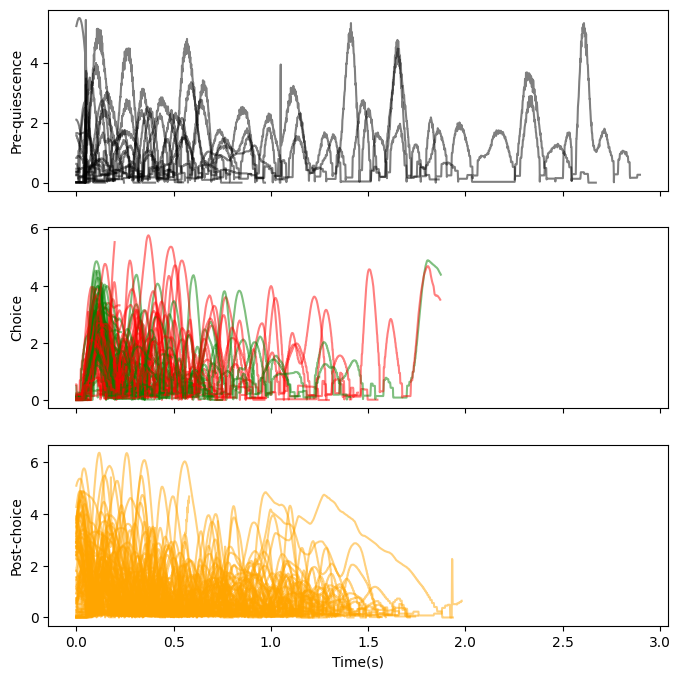

In [245]:
# Keep only movements which fall inside the trial epoch
movements = processed_quiescence['movement_onset'][00:600].reset_index()  

# Keep entire movement, even if it falls on the next trial epoch
# reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
# movements = reduced['movement_onset'][0:600].reset_index()

trial_epochs = ['trial_start', 'quiescence', 'stim_on', 'movement', 'post_choice']
colors_to_use_correct = ['black', 'purple', 'blue', 'green', 'orange']
colors_to_use_incorrect = ['black', 'purple', 'blue', 'red', 'orange']

trial_epochs_plot = ['trial_start', 'movement', 'post_choice']

new_df = df.copy()
# Calculate time step (assuming uniform spacing)
dt = list(df['time'])[1] - list(df['time'])[0]
# Calculate first derivative using central differences
new_df['wheel_vel'] = np.abs(np.gradient(new_df['wheel_pos'], dt))

fig, axs = plt.subplots(nrows=len(trial_epochs_plot), ncols=1, sharex=True, sharey=False, figsize=[8, 8])

for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
    movement_init = movement_onset
    movement_end = movements['movement_onset'][m+1]
    movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
    next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
    movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
    movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel']

    norm_movement_time = movement_time - list(movement_time)[0]
    
    # Plot
    feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
    trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]

    if feedback == 1.:
        colors = colors_to_use_correct[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
    else:
        colors = colors_to_use_incorrect[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        
    if movement_bool == 1.0:
        if trial_epoch == 'trial_start':
            ax = axs[0]
            ax.plot(norm_movement_time, movement_wheel, color=colors, label=trial_epoch, alpha=0.5)
        elif trial_epoch == 'movement':
            ax = axs[1]
            ax.plot(norm_movement_time, movement_wheel, color=colors, label=trial_epoch, alpha=0.5)
        elif trial_epoch == 'post_choice':
            ax = axs[2]
            ax.plot(norm_movement_time, movement_wheel, color=colors, label=trial_epoch, alpha=0.5)
    
    axs[2].set_xlabel('Time(s)')
    axs[0].set_ylabel('Pre-quiescence')
    axs[1].set_ylabel('Choice')
    axs[2].set_ylabel('Post-choice')
    # axs[len(metrics)-1].set_xlim([55, 105])
    # axs[me].set_ylim([-.5, 2.2])

### Average movement per trial epoch

In [168]:
def normalize_movements(processed_quiescence, df, len_snippet, entire_movement=False):


    if entire_movement:
        # Keep entire movement, even if it falls on the next trial epoch
        reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
        movements = reduced['movement_onset'].reset_index()
    else:
        # Keep only movements which fall inside the trial epoch
        movements = processed_quiescence['movement_onset'].reset_index()  

    movements_norm = pd.DataFrame(columns=['time', 'wheel', 'wheel_vel', 'abs_wheel_vel', 'trial_epoch', 'trial', 
                                        'choice', 'feedback', 'next_feedback'])

    new_df = df.copy()
    # Calculate time step (assuming uniform spacing)
    dt = list(df['time'])[1] - list(df['time'])[0]
    # Calculate first derivative using central differences
    new_df['wheel_vel'] = np.gradient(new_df['wheel_pos'], dt)
    new_df['wheel_vel_abs'] = np.abs(new_df['wheel_vel'])
    
    # If timestep is too big because of missing data, remove velocity value
    new_df['dt'] = new_df['time'] * 0
    new_df['dt'][1:] = np.diff(df['time'])
    # new_df['dt'][:-1] = np.diff(df['time'])
    new_df.loc[new_df['dt'] > 0.0015, 'wheel_vel'] = np.nan
    new_df.loc[new_df['dt'] > 0.0015, 'wheel_vel_abs'] = np.nan


    for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
        movement_init = movement_onset
        movement_end = movements['movement_onset'][m+1]
        movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
        next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
        movement_time = new_df.loc[(new_df['time']>movement_init-.04) & (new_df['time']<=movement_end+.04), 'time']
        movement_wheel = new_df.loc[(new_df['time']>movement_init-.04) & (new_df['time']<=movement_end+.04), 'wheel_pos']
        movement_wheel_vel = new_df.loc[(new_df['time']>movement_init-.04) & (new_df['time']<=movement_end+.04), 'wheel_vel']
        movement_abs_wheel_vel = new_df.loc[(new_df['time']>movement_init-.04) & (new_df['time']<=movement_end+.04), 'wheel_vel_abs']

        # Check if data exists and if it corresponds to a movement (if not, skip?)
        if (len(movement_time)> 3) & (movement_bool==1.0):
            feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
            next_feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'next_feedback'])[0]
            choice = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'choice'])[0]
            trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
            trial = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial'])[0]

            rescaled_wheel = interpolate(movement_time, movement_wheel, len_snippet, False)
            rescaled_wheel = rescaled_wheel - list(rescaled_wheel)[0]
            rescaled_wheel_vel = interpolate(movement_time, movement_wheel_vel, len_snippet, False)
            rescaled_abs_wheel_vel = interpolate(movement_time, movement_abs_wheel_vel, len_snippet, False)
            
            movement_df = pd.DataFrame(columns=['time', 'wheel', 'wheel_vel', 'abs_wheel_vel', 'trial_epoch', 'trial',
                                                'choice', 'feedback', 'next_feedback'], index=range(len_snippet))
            
            # Save data per movement
            movement_df['time'] = np.array(np.arange(0, len_snippet), dtype=float)
            movement_df['wheel'] = rescaled_wheel
            movement_df['wheel_vel'] = rescaled_wheel_vel
            movement_df['abs_wheel_vel'] = rescaled_abs_wheel_vel
            movement_df['trial_epoch'] = trial_epoch
            movement_df['trial'] = trial
            movement_df['choice'] = choice
            movement_df['feedback'] = feedback
            movement_df['next_feedback'] = next_feedback
            
            if m == 0:
                movements_norm = movement_df
            else:
                movements_norm = movements_norm.append(movement_df)

    return movements_norm


def plot_trial_epoch_norm(movements_norm):
    
    trial_epochs = ['trial_start', 'movement', 'post_choice']
    hue = 'choice'
    style = 'feedback'

    for e, epoch in enumerate(trial_epochs):
        fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[5, 7])
        
        use_data = movements_norm.loc[movements_norm['trial_epoch'] == epoch].reset_index()
        sns.lineplot(x='time', y='wheel', hue=hue, style=style, data=use_data, ax=axs[0])
        axs[0].set_xlabel('Time (bins)')
        axs[0].set_ylabel('Wheel position')
        axs[0].set_title(epoch)
        sns.lineplot(x='time', y='wheel_vel', hue=hue, style=style, data=use_data, ax=axs[1])
        axs[1].set_xlabel('Time (bins)')
        axs[1].set_ylabel('Wheel velocity')
        axs[1].set_ylim([-1, 1])
        sns.lineplot(x='time', y='abs_wheel_vel', hue=hue, style=style, data=use_data, ax=axs[2])
        axs[2].set_xlabel('Time (bins)')
        axs[2].set_ylabel('Wheel speed')
        axs[2].set_ylim([0, 1.5])
        plt.show()


/tmp/ipykernel_16056/1624868286.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['dt'][1:] = np.diff(df['time'])
/tmp/ipykernel_16056/1624868286.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['wheel_vel'][1:] = np.diff(new_df['wheel_pos'])/new_df['dt'][1:]
/tmp/ipykernel_16056/1624868286.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movements_norm = movements_norm.append(movement_df)
/tmp/ipykernel_16056/1624868286.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pa

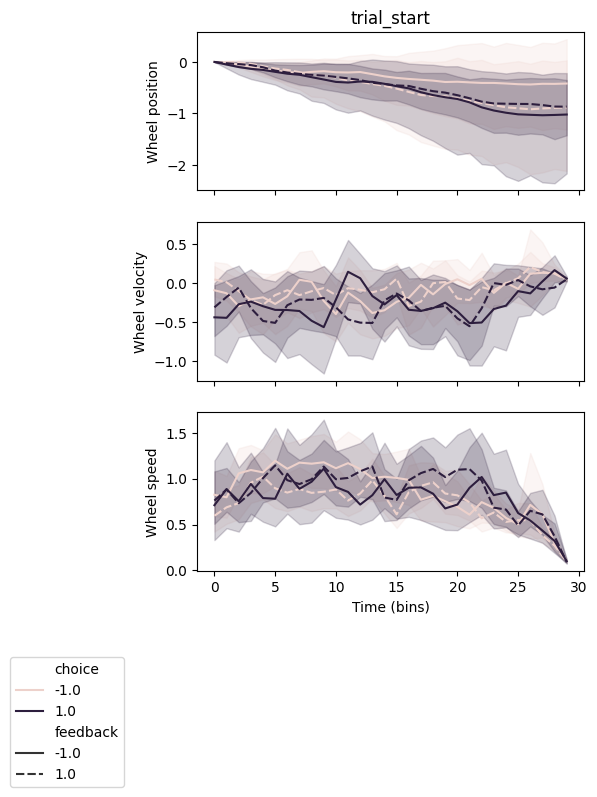

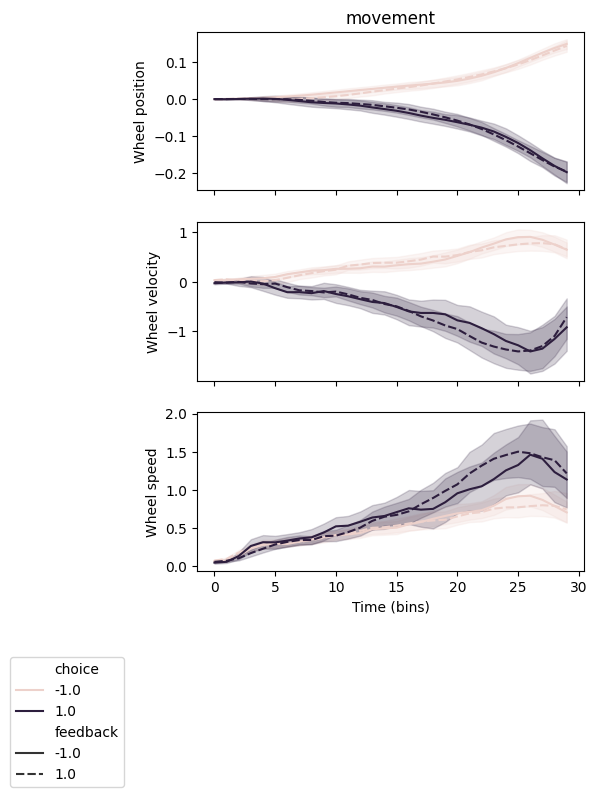

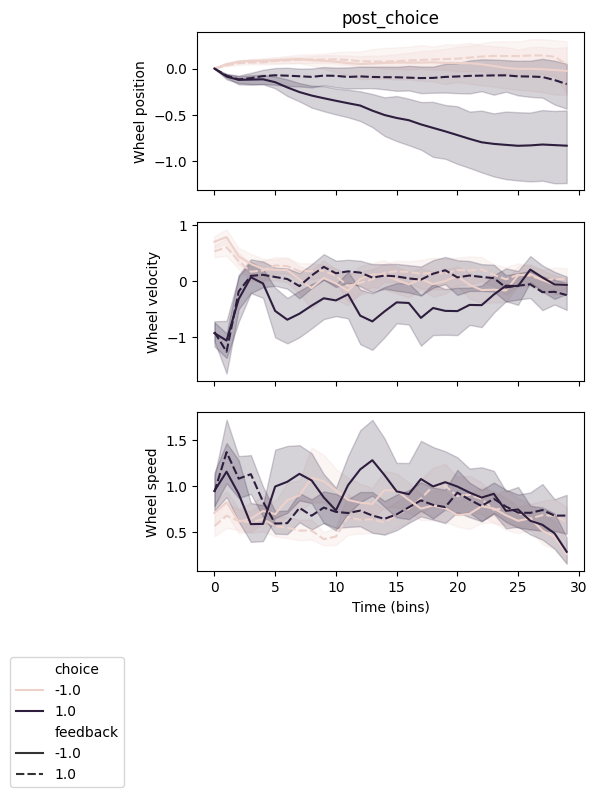

In [289]:
len_snippet = 30

processed_data = os.listdir(processed_data_path)
wheel_data = os.listdir(wheel_data_path)

for wheel in wheel_data[0:1]:
    eid = wheel[-36:]
    eid = '32088c28-be54-4e32-9f8e-a03c4f85c6d0'

    phase='1'
    os.chdir(wheel_data_path)
    df = pickle.load(open('wheel_movements_1_'+eid, "rb"))
    os.chdir(processed_data_path)
    processed_data = pickle.load(open('processed_quiescence_1_' + eid, "rb"))
    movements_norm = normalize_movements(processed_data, df, len_snippet, entire_movement=False)
    movements_norm = movements_norm.loc[movements_norm['choice'].isin([1., -1.])]
    plot_trial_epoch_norm(movements_norm, eid, phase)

In [283]:
len_snippet = 30

processed_data = os.listdir(processed_data_path)
wheel_data = os.listdir(wheel_data_path)

for wheel in wheel_data[0:1]:
    eid = wheel[-36:]
    eid = '604e1da8-1e3d-41c4-a29e-21d573a0b84c'
    if 'last' in wheel:
        phase='last'
        os.chdir(wheel_data_path)
        df = pickle.load(open('wheel_movements_last_'+eid, "rb"))

        os.chdir(processed_data_path)
        processed_data = pickle.load(open('processed_quiescence_last_' + eid, "rb"))
        movements_norm = normalize_movements(processed_data, df, len_snippet, entire_movement=False)
        movements_norm = movements_norm.loc[movements_norm['choice'].isin([1., -1.])]
        plot_trial_epoch_norm(movements_norm, eid, phase)
    elif '1' in wheel:
        phase='1'
        os.chdir(wheel_data_path)
        df = pickle.load(open('wheel_movements_1_'+eid, "rb"))
        os.chdir(processed_data_path)
        processed_data = pickle.load(open('processed_quiescence_1_' + eid, "rb"))
        movements_norm = normalize_movements(processed_data, df, len_snippet, entire_movement=False)
        movements_norm = movements_norm.loc[movements_norm['choice'].isin([1., -1.])]
        plot_trial_epoch_norm(movements_norm, eid, phase)


FileNotFoundError: [Errno 2] No such file or directory: 'wheel_movements_last_604e1da8-1e3d-41c4-a29e-21d573a0b84c'

In [280]:
# New one
def normalize_movements(processed_quiescence, df, len_snippet, entire_movement=False):

    if entire_movement:
        # Keep entire movement, even if it falls on the next trial epoch
        reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
        movements = reduced['movement_onset'].reset_index()
    else:
        # Keep only movements which fall inside the trial epoch
        movements = processed_quiescence['movement_onset'].reset_index()  
            
    movements_norm = pd.DataFrame(columns=['time', 'wheel', 'wheel_vel', 'abs_wheel_vel', 'trial_epoch', 'trial', 
                                        'choice', 'feedback', 'next_feedback'])

    new_df = df.copy()

    # If timestep is too big because of missing data, remove velocity value
    new_df['dt'] = new_df['time'] * np.nan
    new_df['dt'][1:] = np.diff(df['time'])

    # Calculate first derivative using central differences
    new_df['wheel_vel'] = new_df['wheel_pos'] * np.nan
    new_df['wheel_vel'][1:] = np.diff(new_df['wheel_pos'])/new_df['dt'][1:]
    new_df['wheel_vel_abs'] = np.abs(new_df['wheel_vel'])


    for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
        movement_init = movement_onset
        movement_end = movements['movement_onset'][m+1]
        movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
        next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
        movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
        movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_pos']
        movement_wheel_vel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel']
        movement_abs_wheel_vel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel_abs']
        
        if (len(movement_time)> 3) & (movement_bool==1.):
            feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
            next_feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'next_feedback'])[0]
            choice = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'choice'])[0]
            trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
            trial = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial'])[0]

            rescaled_wheel = interpolate(movement_time, movement_wheel, len_snippet, False)
            rescaled_wheel = rescaled_wheel - list(rescaled_wheel)[0]
            rescaled_wheel_vel = interpolate(movement_time, movement_wheel_vel, len_snippet, False)
            rescaled_abs_wheel_vel = interpolate(movement_time, movement_abs_wheel_vel, len_snippet, False)
            
            movement_df = pd.DataFrame(columns=['time', 'wheel', 'wheel_vel', 'abs_wheel_vel', 'trial_epoch', 'trial',
                                                'choice', 'feedback', 'next_feedback'], index=range(len_snippet))
            
            # Save data per movement
            movement_df['time'] = np.array(np.arange(0, len_snippet), dtype=float)
            movement_df['wheel'] = rescaled_wheel
            movement_df['wheel_vel'] = rescaled_wheel_vel
            movement_df['abs_wheel_vel'] = rescaled_abs_wheel_vel
            movement_df['trial_epoch'] = trial_epoch
            movement_df['trial'] = trial
            movement_df['choice'] = choice
            movement_df['feedback'] = feedback
            movement_df['next_feedback'] = next_feedback
            
            if m == 0:
                movements_norm = movement_df
            else:
                movements_norm = movements_norm.append(movement_df)
    return movements_norm



def plot_trial_epoch_norm(movements_norm, eid, phase):
    
    trial_epochs = ['trial_start', 'movement', 'post_choice']

    hue = 'choice'
    style = 'feedback'

    for e, epoch in enumerate(trial_epochs):
        fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[5, 7])
        
        use_data = movements_norm.loc[movements_norm['trial_epoch'] == epoch].reset_index()
        sns.lineplot(x='time', y='wheel', hue=hue, style=style, data=use_data, ax=axs[0], legend=None)
        axs[0].set_xlabel('Time (bins)')
        axs[0].set_ylabel('Wheel position')
        axs[0].set_title(epoch)
        sns.lineplot(x='time', y='wheel_vel', hue=hue, style=style, data=use_data, ax=axs[1], legend=None)
        axs[1].set_xlabel('Time (bins)')
        axs[1].set_ylabel('Wheel velocity')
        # axs[1].set_ylim([-1, 1])
        sns.lineplot(x='time', y='abs_wheel_vel', hue=hue, style=style, data=use_data, ax=axs[2])
        axs[2].set_xlabel('Time (bins)')
        axs[2].set_ylabel('Wheel speed')
        axs[2].legend(loc='upper left', bbox_to_anchor=(-.5, -0.5))
        # axs[2].set_ylim([0, 1.5])
        plt.savefig(str(eid+'_'+phase+epoch+'.svg'),dpi=500)

KeyboardInterrupt: 

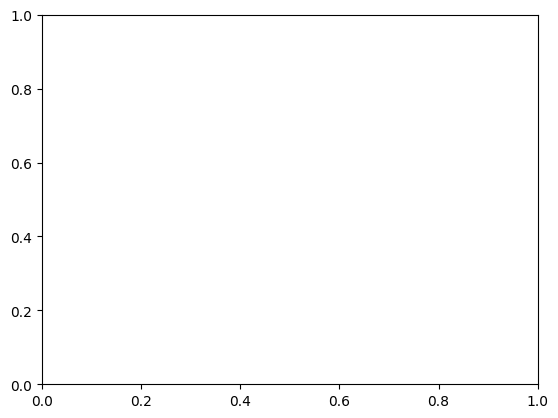

In [266]:
use_data = movements_norm.loc[movements_norm['trial_epoch'].isin(['trial_start', 'movement', 'post_choice'])]
sns.lineplot(x='time', y='abs_wheel_vel', hue='trial_epoch', data=use_data)
plt.xlabel('Time (bins)')
plt.ylabel('Wheel speed')

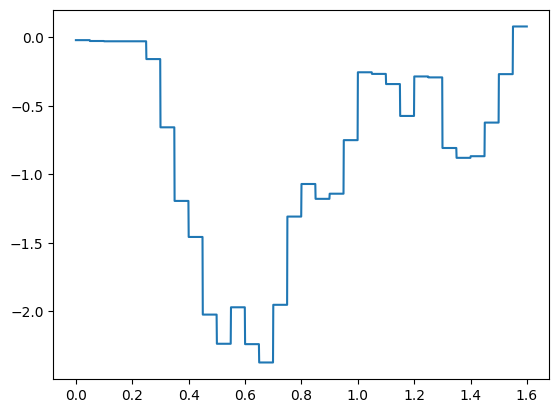

In [14]:
reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
movements = reduced['movement_onset'][0:30]

for m, movement_onset in enumerate(movements[:1]):
    movement_init = movement_onset
    movement_end = movements[m+1]
    movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
    next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movements[m+1], 'movement'])[0]
    movement_time = df.loc[(df['time']>movement_init-.05) & (df['time']<=movement_end+.05), 'time']
    movement_wheel = df.loc[(df['time']>movement_init-.05) & (df['time']<=movement_end+.05), 'wheel']
    if movement_bool == 1.0:
        plt.plot(movement_time, movement_wheel)
    else:
        plt.plot(movement_time, movement_wheel, color='grey', linewidth=1)

In [68]:
def interpolate(time_snippet, snippet, size, plot):
    x = np.arange(0, len(time_snippet))
    y = snippet
    f = interp1d(x, y, 'cubic')
    
    # New grid coordinates
    new_x = np.linspace(0, len(x)-1, size)  # Upscale to 6 columns

    # Interpolate values at new grid coordinates
    rescaled_array = f(new_x)
    
    if plot == True:
        # plt.plot(x, y, 'o', new_x, rescaled_array, '-')
        plt.plot(new_x, rescaled_array, '-')
        plt.plot(x, snippet)
        plt.xlabel('Time')
        plt.ylabel('Data')
        plt.show()
            
    return rescaled_array

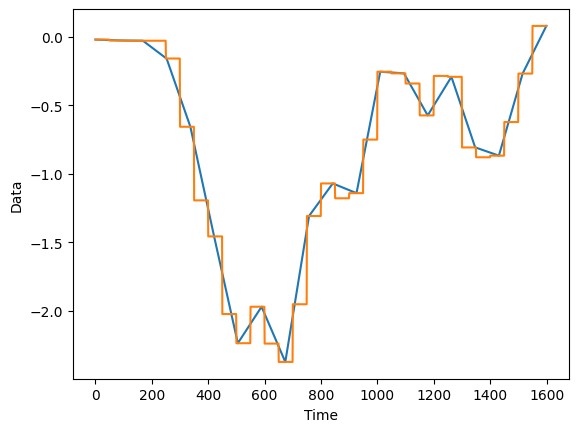

In [26]:
rescaled_array = interpolate(movement_time, movement_wheel, 20, True)

In [ ]:
# TODO
# for a single movement plot derivatives